Current directory: d:\vscProjects\GA-ACO-SOPComparison\src

Available directories and files:
Directory: comparison_results
Directory: results
Directory: resultsACO
Found data directory: ../data
Running 10 trials for each algorithm on each instance...


Running experiments: 100%|██████████| 140/140 [20:03<00:00,  8.60s/it]



SUMMARY OF EXPERIMENTAL RESULTS

Cost Statistics (lower is better):
   algorithm   instance  cost_min  cost_mean    cost_std
0        ACO  ESC07.sop      2125     2125.0    0.000000
1        ACO  ESC11.sop      2075     2179.7   97.807123
2        ACO  ESC12.sop      1675     1675.0    0.000000
3        ACO  ESC25.sop      2040     2100.5   99.372755
4        ACO  ESC47.sop      2365     2513.3  146.724269
5        ACO  ESC63.sop        62       62.7    0.674949
6        ACO  ESC78.sop     19580    20216.0  411.290651
7         GA  ESC07.sop      2125     2125.0    0.000000
8         GA  ESC11.sop      2145     2329.1  152.079986
9         GA  ESC12.sop      1675     1752.6   41.711176
10        GA  ESC25.sop      3266     3801.5  356.119596
11        GA  ESC47.sop      5428     6872.3  872.887170
12        GA  ESC63.sop        89       98.7    6.976946
13        GA  ESC78.sop     19740    20362.0  319.480481

Time Statistics (seconds):
   algorithm   instance   time_min  time_mean   

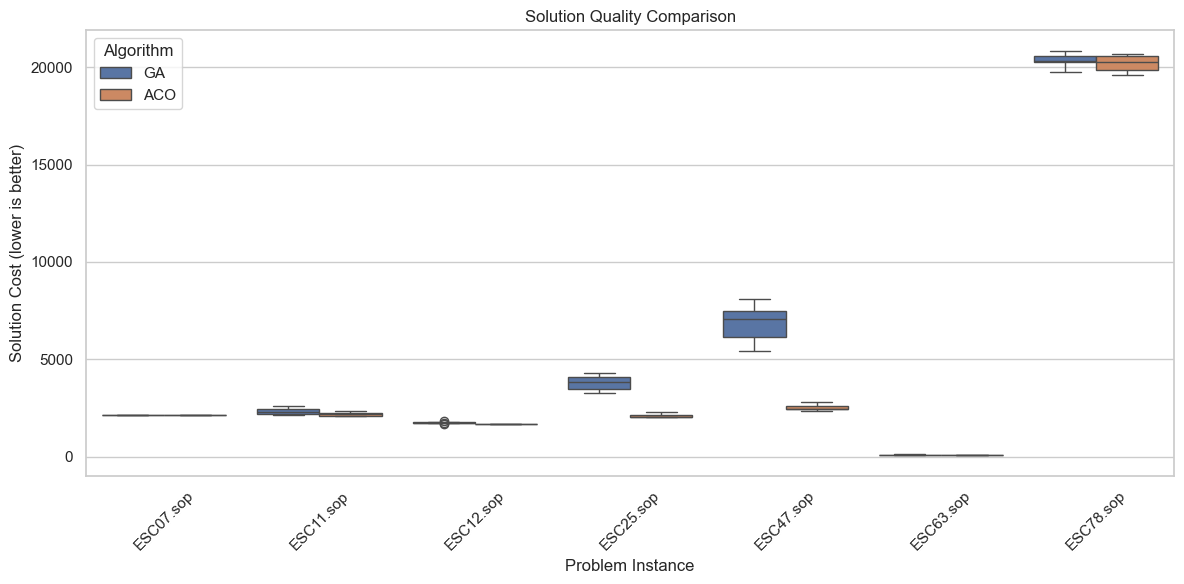

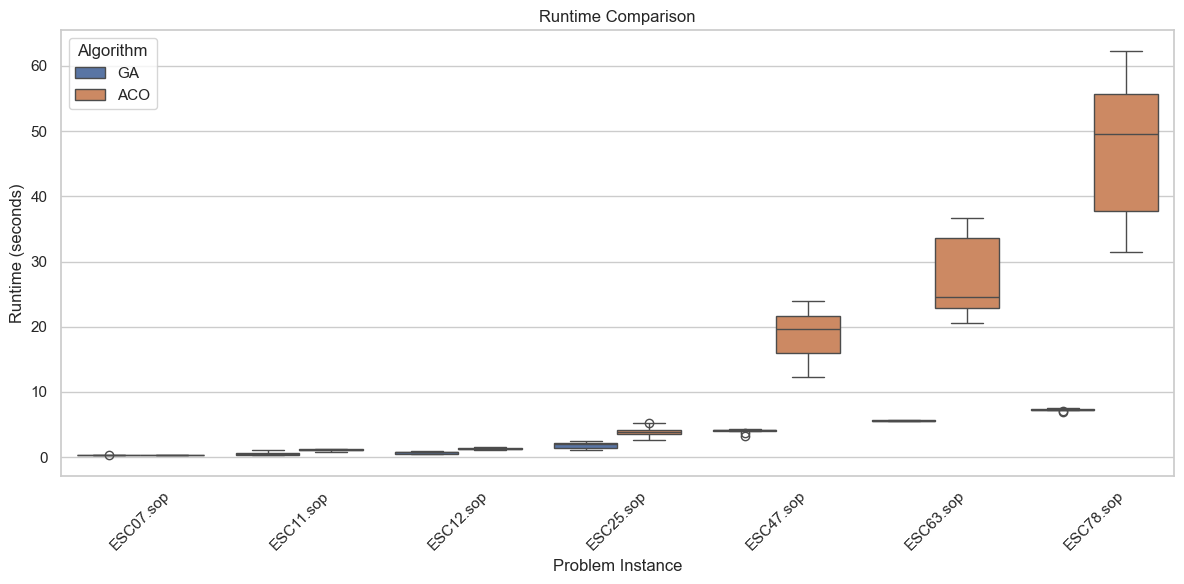

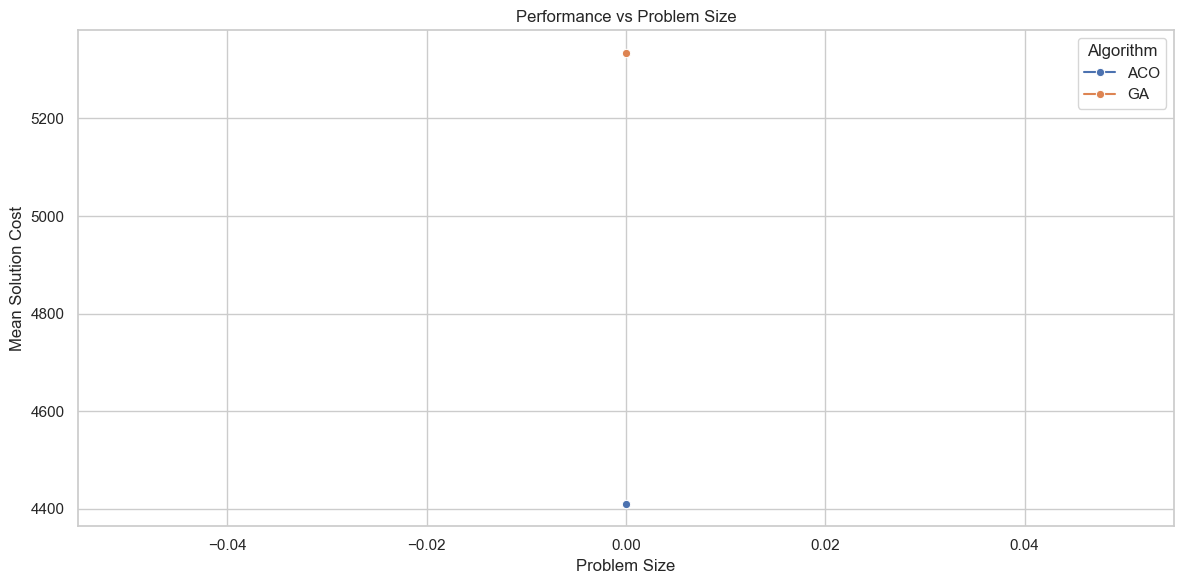

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import multiprocessing
from concurrent.futures import ProcessPoolExecutor

class SOP:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file_name = Path(file_path).name
        self.nodes, self.costs, self.precedence = self.parse_file(file_path)
        self.size = len(self.nodes)
        self.before = defaultdict(set)
        self.after = defaultdict(set)
        self.build_precedence_graph()

    def parse_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()

        dimension = next(int(line.strip().split(':')[1]) 
                         for line in lines if line.startswith('DIMENSION'))
        
        matrix_start = next(i for i, line in enumerate(lines) 
                           if line.startswith('EDGE_WEIGHT_SECTION')) + 1
        
        if lines[matrix_start].strip().isdigit():
            matrix_start += 1
        
        matrix_data = []
        for i in range(matrix_start, matrix_start + dimension):
            row = list(map(int, lines[i].strip().split()))
            matrix_data.append(row)
        
        costs_matrix = np.array(matrix_data)
        
        nodes = list(range(1, dimension + 1))
        costs = {}
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] != -1:
                    costs[(i+1, j+1)] = costs_matrix[i, j]
        
        precedence = []
        for i in range(dimension):
            for j in range(dimension):
                if costs_matrix[i, j] == -1 and i != j:
                    precedence.append((j+1, i+1))
        
        return nodes, costs, precedence

    def build_precedence_graph(self):
        for u, v in self.precedence:
            self.before[v].add(u)
            self.after[u].add(v)
        
        changed = True
        while changed:
            changed = False
            for node in self.nodes:
                old_before = self.before[node].copy()
                for b in old_before:
                    self.before[node].update(self.before[b])
                if len(self.before[node]) > len(old_before):
                    changed = True
                    
                old_after = self.after[node].copy()
                for a in old_after:
                    self.after[node].update(self.after[a])
                if len(self.after[node]) > len(old_after):
                    changed = True

    def is_valid(self, path):
        position = {node: i for i, node in enumerate(path)}
        
        for i, node in enumerate(path):
            for before_node in self.before[node]:
                if before_node in position and position[before_node] >= i:
                    return False
                    
        for i in range(len(path) - 1):
            if (path[i], path[i+1]) not in self.costs:
                return False
                
        return True

    def total_cost(self, path):
        return sum(self.costs.get((path[i], path[i+1]), float('inf')) 
                  for i in range(len(path) - 1))

class GeneticSolver:
    def __init__(self, sop, pop_size=50, generations=100, 
                 mutation_rate=0.15, crossover_rate=0.85, 
                 elite_size=5, tournament_size=3,
                 max_stagnation=30):
        self.sop = sop
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elite_size = elite_size
        self.tournament_size = tournament_size
        self.max_stagnation = max_stagnation
        
        self.population = []
        self.best_solution = None
        self.best_cost = float('inf')
        self.last_improvement = 0
        self.generation_stats = []

    def create_initial_population(self):
        """Creates a diverse initial population using mixed strategies"""
        self.population = []
        
        # Find valid start and end nodes based on precedence constraints
        start_candidates = [n for n in self.sop.nodes if not self.sop.before[n]]
        end_candidates = [n for n in self.sop.nodes if not self.sop.after[n]]
        
        start_node = start_candidates[0] if start_candidates else 1
        end_node = end_candidates[0] if end_candidates else self.sop.size
        
        # Generate 60% of population with a greedy-random approach
        greedy_count = int(0.6 * self.pop_size)
        for _ in range(greedy_count):
            path = self.generate_valid_path(start_node, end_node, greedy_bias=0.7)
            if path and path not in self.population:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()
        
        # Fill the rest with random solutions
        while len(self.population) < self.pop_size:
            path = self.generate_valid_path(start_node, end_node, greedy_bias=0.3)
            if path and path not in self.population:
                self.population.append(path)
                cost = self.sop.total_cost(path)
                if cost < self.best_cost:
                    self.best_cost = cost
                    self.best_solution = path.copy()

    def generate_valid_path(self, start_node, end_node, greedy_bias=0.5):
        """Generate a valid path with tunable greediness"""
        path = [start_node]
        remaining = set(self.sop.nodes) - {start_node, end_node}
        
        current_node = start_node
        max_attempts = 100
        attempts = 0
        
        while remaining and attempts < max_attempts:
            candidates = [n for n in remaining if 
                         all(pred not in remaining for pred in self.sop.before[n]) and
                         (current_node, n) in self.sop.costs]
            
            if not candidates:
                attempts += 1
                if attempts >= max_attempts:
                    return None
                path = [start_node]
                remaining = set(self.sop.nodes) - {start_node, end_node}
                current_node = start_node
                continue
                
            costs = [self.sop.costs.get((current_node, n), float('inf')) for n in candidates]
            
            # Use greedy selection with probability greedy_bias
            if random.random() < greedy_bias:
                # Choose with probability inversely proportional to cost
                min_cost = min(costs)
                max_cost = max(costs)
                if min_cost == max_cost:
                    weights = [1] * len(candidates)
                else:
                    weights = [(max_cost - c + 1) / (max_cost - min_cost + 1) for c in costs]
                total = sum(weights)
                weights = [w/total for w in weights]
                next_node = random.choices(candidates, weights=weights, k=1)[0]
            else:
                # Random choice
                next_node = random.choice(candidates)
            
            path.append(next_node)
            remaining.remove(next_node)
            current_node = next_node
            
        if not remaining:
            path.append(end_node)
            return path
        return None

    def select_parents(self):
        """Tournament selection with adaptive tournament size"""
        # Check if population is converging
        if len(self.generation_stats) > 10:
            costs = [self.sop.total_cost(p) for p in self.population]
            std_dev = np.std(costs)
            if std_dev < (self.best_cost * 0.01):
                # Smaller tournament for more diversity when converging
                t_size = max(2, self.tournament_size - 1)
            else:
                t_size = self.tournament_size
        else:
            t_size = self.tournament_size
            
        def tournament():
            candidates = random.sample(range(len(self.population)), t_size)
            return self.population[min(candidates, key=lambda i: self.sop.total_cost(self.population[i]))]
            
        return tournament(), tournament()

    def ordered_crossover(self, parent1, parent2):
        """Enhanced ordered crossover that preserves precedence relationships"""
        if random.random() > self.crossover_rate:
            return parent1.copy()  # No crossover
            
        size = len(parent1)
        
        # Try to find a crossover that preserves precedence relationships
        valid_crossover = False
        max_attempts = 5
        
        for _ in range(max_attempts):
            # Choose crossover points
            start, end = sorted(random.sample(range(size), 2))
            child = [None] * size
            child[start:end+1] = parent1[start:end+1]
            
            # Fill with values from parent2 that aren't already in child
            remaining = [gene for gene in parent2 if gene not in child[start:end+1]]
            
            # Fill before segment
            for i in range(start):
                child[i] = remaining.pop(0)
                
            # Fill after segment
            for i in range(end+1, size):
                child[i] = remaining.pop(0)
            
            # Check if valid
            if self.sop.is_valid(child):
                valid_crossover = True
                break
        
        if not valid_crossover:
            # If we couldn't find a valid crossover, repair the last attempt
            child = self.repair(child)
            
        return child if child else parent1.copy()

    def repair(self, path):
        """Repair an invalid solution to satisfy precedence constraints"""
        valid_path = []
        candidates = set(path)
        
        while candidates:
            # Find nodes that have all their predecessors already in valid_path
            ready = [n for n in candidates 
                    if all(pred not in candidates for pred in self.sop.before[n])]
            
            if not ready:
                # If no nodes are ready, this path can't be repaired
                return None
                
            # Choose the node that appears earliest in the original path
            next_node = min(ready, key=lambda n: path.index(n))
            valid_path.append(next_node)
            candidates.remove(next_node)
        
        return valid_path

    def mutate(self, path):
        """Multi-operator mutation with repair mechanism"""
        if random.random() > self.mutation_rate:
            return path
            
        mutated = path.copy()
        size = len(path)
        
        # Choose mutation operator
        op = random.random()
        max_attempts = 10
        
        if op < 0.6:  # 60% swap mutation (least disruptive)
            for _ in range(max_attempts):
                i, j = sorted(random.sample(range(size), 2))
                mutated[i], mutated[j] = mutated[j], mutated[i]
                
                if self.sop.is_valid(mutated):
                    return mutated
                
                # Undo swap
                mutated[i], mutated[j] = mutated[j], mutated[i]
                
        elif op < 0.9:  # 30% insertion mutation
            for _ in range(max_attempts):
                i = random.randint(0, size-1)
                j = random.randint(0, size-1)
                if i != j:
                    # Remove element at i and insert at j
                    value = mutated.pop(i)
                    mutated.insert(j if j < i else j-1, value)
                    
                    if self.sop.is_valid(mutated):
                        return mutated
                
                # Restore original
                mutated = path.copy()
                
        else:  # 10% inversion mutation (most disruptive)
            for _ in range(max_attempts):
                i, j = sorted(random.sample(range(size), 2))
                # Invert the segment
                mutated[i:j+1] = reversed(mutated[i:j+1])
                
                if self.sop.is_valid(mutated):
                    return mutated
                
                # Restore original
                mutated = path.copy()
        
        # If all attempts failed, try repair
        repaired = self.repair(mutated)
        return repaired if repaired else path

    def evolve(self):
        """Evolution with adaptive operators and elitism"""
        # Sort population by fitness
        sorted_pop = sorted(self.population, 
                          key=lambda p: self.sop.total_cost(p))
        
        # Keep elite individuals
        new_population = sorted_pop[:self.elite_size]
        
        # Generate rest through selection, crossover, and mutation
        while len(new_population) < self.pop_size:
            parent1, parent2 = self.select_parents()
            child = self.ordered_crossover(parent1, parent2)
            child = self.mutate(child)
            
            if child and self.sop.is_valid(child):
                new_population.append(child)
            
        self.population = new_population
        
        # Update best solution
        current_best = min(self.population, key=self.sop.total_cost)
        current_cost = self.sop.total_cost(current_best)
        
        if current_cost < self.best_cost:
            self.best_cost = current_cost
            self.best_solution = current_best.copy()
            self.last_improvement = len(self.generation_stats)
            
        # Calculate statistics
        costs = [self.sop.total_cost(p) for p in self.population]
        self.generation_stats.append({
            'generation': len(self.generation_stats),
            'best_cost': self.best_cost,
            'avg_cost': np.mean(costs),
            'min_cost': current_cost,
            'diversity': np.std(costs)
        })

    def solve(self, verbose=True):
        """Solve with early stopping"""
        start_time = time.time()
        
        self.create_initial_population()
        
        for gen in range(self.generations):
            self.evolve()
            
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}/{self.generations}, " 
                      f"Best cost: {self.best_cost}")
            
            # Early stopping if no improvement
            if gen - self.last_improvement > self.max_stagnation:
                if verbose:
                    print(f"Early stopping at generation {gen}: no improvement for {self.max_stagnation} generations")
                break
                
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'generations': len(self.generation_stats),
            'stats': self.generation_stats
        }

class AntColonySolver:
    def __init__(self, sop, ants=50, iterations=100, 
                 alpha=1.0, beta=2.5, rho=0.1, q0=0.9,
                 initial_pheromone=0.1, min_pheromone_factor=0.001, max_pheromone_factor=5.0,
                 local_decay=0.1, max_stagnation=25,
                 candidate_list_size=20, elite_ants=5):
        
        self.sop = sop
        self.ants = ants
        self.iterations = iterations
        self.alpha = alpha  # Pheromone influence
        self.beta = beta    # Heuristic influence
        self.rho = rho      # Pheromone evaporation rate
        self.q0 = q0        # Exploitation vs exploration balance
        self.initial_pheromone = initial_pheromone
        self.local_decay = local_decay
        self.max_stagnation = max_stagnation
        self.candidate_list_size = candidate_list_size  # Candidate list strategy
        self.elite_ants = elite_ants  # Number of elite ants for pheromone update
        
        # Dynamic parameters - will be adjusted during search
        self.current_q0 = q0
        self.current_alpha = alpha
        self.current_beta = beta
        
        # Pheromone bounds - will be dynamically adjusted
        self.min_pheromone_factor = min_pheromone_factor
        self.max_pheromone_factor = max_pheromone_factor
        self.min_pheromone = None  # Will be calculated dynamically
        self.max_pheromone = None  # Will be calculated dynamically
        
        # Initialize pheromone matrix
        self.pheromone = {}
        for i in self.sop.nodes:
            for j in self.sop.nodes:
                if (i, j) in self.sop.costs:
                    self.pheromone[(i, j)] = initial_pheromone
        
        # Precompute candidate lists for each node for efficiency
        self.candidate_lists = self.precompute_candidate_lists()
        
        # Compute heuristic information with multiple factors
        self.heuristic = {}
        for (i, j), cost in self.sop.costs.items():
            # Enhanced heuristic with precedence consideration
            precedence_factor = 1.0
            if j in self.sop.after[i]:
                # If j must come after i due to precedence, increase attraction
                precedence_factor = 2.0
            
            # Base heuristic is inverse of cost
            base_heuristic = 1.0 / cost if cost > 0 else 0.0
            
            # Enhanced heuristic considering both cost and precedence
            self.heuristic[(i, j)] = base_heuristic * precedence_factor
        
        # Solution tracking
        self.best_solution = None
        self.best_cost = float('inf')
        self.last_improvement = 0
        self.best_solutions_history = []  # For adaptive memory
        self.iteration_stats = []
        self.convergence_factor = 0.0
        
        # Local search configuration
        self.local_search_frequency = 0.2  # Apply local search to 20% of solutions
        
        # Initialize pheromone bounds
        self.update_pheromone_bounds()
    
    def precompute_candidate_lists(self):
        """
        Precompute candidate lists for each node based on cost and precedence
        This is a performance optimization for larger instances
        """
        candidate_lists = {}
        
        for i in self.sop.nodes:
            # Get all possible destinations from i
            possible_destinations = [(j, self.sop.costs.get((i, j), float('inf'))) 
                                     for j in self.sop.nodes 
                                     if (i, j) in self.sop.costs and i != j]
            
            # Sort by cost (cheaper destinations first)
            possible_destinations.sort(key=lambda x: x[1])
            
            # Take the top candidates
            candidate_lists[i] = [j for j, _ in possible_destinations[:self.candidate_list_size]]
            
        return candidate_lists
    
    def update_pheromone_bounds(self):
        """
        Dynamically update pheromone bounds based on best solution
        This is a key feature of MAX-MIN Ant System that prevents stagnation
        """
        if self.best_cost < float('inf'):
            # Calculate new bounds based on best found solution
            self.max_pheromone = self.max_pheromone_factor / self.best_cost
            self.min_pheromone = self.max_pheromone * self.min_pheromone_factor
        else:
            # Default values if no solution found yet
            self.max_pheromone = 1.0
            self.min_pheromone = 0.001
    
    def construct_solution(self, use_candidate_lists=True):
        """
        Construct a solution for a single ant using a hybrid ACO approach with:
        - Candidate list strategy for performance
        - Dynamic alpha/beta/q0 parameters
        - Intelligent handling of precedence constraints
        """
        # Find valid start and end nodes based on precedence constraints
        start_candidates = [n for n in self.sop.nodes if not self.sop.before[n]]
        start_node = start_candidates[0] if start_candidates else 1
        
        # Initialize the solution with the start node
        current_path = [start_node]
        unvisited = set(self.sop.nodes) - {start_node}
        current_node = start_node
        
        # Construct the rest of the solution
        while unvisited:
            # Determine feasible nodes (respecting precedence constraints)
            feasible_nodes = [node for node in unvisited 
                             if all(pred not in unvisited for pred in self.sop.before[node])
                             and (current_node, node) in self.sop.costs]
            
            if not feasible_nodes:
                # No feasible nodes - try to repair
                return self.repair_solution(current_path)
            
            # Use candidate list for efficiency if enabled
            if use_candidate_lists and feasible_nodes:
                # Filter feasible nodes by candidate list
                candidates = [n for n in self.candidate_lists.get(current_node, []) 
                             if n in feasible_nodes]
                
                # If candidate list is empty or too small, use all feasible nodes
                if len(candidates) < min(3, len(feasible_nodes)):
                    candidates = feasible_nodes
            else:
                candidates = feasible_nodes
            
            # Select next node based on pheromone and heuristic
            next_node = self.select_next_node(current_node, candidates)
            
            # Apply local pheromone update (ACS-style)
            self.local_pheromone_update(current_node, next_node)
            
            # Update the solution
            current_path.append(next_node)
            unvisited.remove(next_node)
            current_node = next_node
        
        # Apply local search with some probability
        if random.random() < self.local_search_frequency:
            current_path = self.local_search(current_path)
            
        # Ensure solution is valid
        if not self.sop.is_valid(current_path):
            current_path = self.repair_solution(current_path)
            
        return current_path
    
    def select_next_node(self, current_node, feasible_nodes):
        """
        Select the next node using parameterized exploitation/exploration balance
        with problem-specific heuristics
        """
        if not feasible_nodes:
            return None
            
        # Pseudorandom proportional rule (from Ant Colony System)
        if random.random() < self.current_q0:
            # Exploitation - choose best option deterministically
            return max(feasible_nodes, 
                      key=lambda j: self.pheromone.get((current_node, j), 0) ** self.current_alpha * 
                                    self.heuristic.get((current_node, j), 0) ** self.current_beta)
        else:
            # Exploration - choose probabilistically
            total = 0.0
            probabilities = []
            
            for node in feasible_nodes:
                pheromone = self.pheromone.get((current_node, node), 0)
                heuristic_value = self.heuristic.get((current_node, node), 0)
                
                # Apply current parameters
                prob = (pheromone ** self.current_alpha) * (heuristic_value ** self.current_beta)
                probabilities.append(prob)
                total += prob
            
            if total == 0:
                # If all probabilities are zero, choose randomly
                return random.choice(feasible_nodes)
            
            # Convert to probabilities
            probabilities = [p/total for p in probabilities]
            
            # Select based on probabilities
            return random.choices(feasible_nodes, weights=probabilities, k=1)[0]
    
    def local_pheromone_update(self, i, j):
        """
        Apply local pheromone update to encourage exploration (ACS-style)
        """
        if (i, j) in self.pheromone:
            self.pheromone[(i, j)] = (1 - self.local_decay) * self.pheromone[(i, j)] + \
                                     self.local_decay * self.initial_pheromone
    
    def global_pheromone_update(self, solutions_and_costs):
        """
        Advanced global pheromone update with:
        - Multiple-ant update (top k solutions)
        - MMAS pheromone bounds
        - Rank-based update weighting
        """
        # Apply evaporation to all edges
        for key in self.pheromone:
            self.pheromone[key] *= (1 - self.rho)
        
        # Rank solutions and apply weighted updates
        for rank, (path, cost) in enumerate(solutions_and_costs):
            # Rank-based weight: higher ranked solutions get more influence
            weight = max(0, self.elite_ants - rank) / self.elite_ants
            
            if weight > 0:
                # Calculate pheromone deposit based on solution quality and rank
                delta = weight * (1.0 / cost) if cost > 0 else 0
                
                # Update pheromone on edges in the solution path
                for i in range(len(path) - 1):
                    edge = (path[i], path[i+1])
                    if edge in self.pheromone:
                        self.pheromone[edge] += self.rho * delta
        
        # Apply MMAS bounds to prevent stagnation
        for key in self.pheromone:
            self.pheromone[key] = min(self.max_pheromone, 
                                     max(self.min_pheromone, self.pheromone[key]))
    
    def repair_solution(self, path):
        """
        Enhanced repair mechanism for invalid solutions
        """
        if not path:
            return None
            
        # Create a new path that respects precedence constraints
        valid_path = []
        remaining = set(path)
        
        while remaining:
            # Find nodes that have all prerequisites satisfied
            valid_candidates = [n for n in remaining 
                              if all(pred in valid_path or pred not in remaining 
                                    for pred in self.sop.before[n])]
            
            if not valid_candidates:
                # If no valid candidates, the path can't be repaired
                return None
            
            # Choose the node that appears earliest in the original path
            next_node = min(valid_candidates, key=lambda n: path.index(n))
            valid_path.append(next_node)
            remaining.remove(next_node)
        
        return valid_path
    
    def local_search(self, solution):
        """
        Apply a fast local search to improve solution quality
        using a restricted neighborhood to save computation time
        """
        if not solution:
            return solution
        
        improved = True
        current_solution = solution.copy()
        current_cost = self.sop.total_cost(current_solution)
        
        # Simple restricted 2-opt local search
        # Only try a limited number of moves to save computation time
        max_attempts = min(30, len(solution))
        attempts = 0
        
        while improved and attempts < max_attempts:
            improved = False
            
            # Try swapping nearby nodes (within window of 5)
            for i in range(len(current_solution) - 1):
                # Only check a few positions ahead to save time
                for j in range(i + 1, min(i + 5, len(current_solution))):
                    # Try swap
                    new_solution = current_solution.copy()
                    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
                    
                    # Check if valid and better
                    if self.sop.is_valid(new_solution):
                        new_cost = self.sop.total_cost(new_solution)
                        if new_cost < current_cost:
                            current_solution = new_solution
                            current_cost = new_cost
                            improved = True
                            break
                
                if improved:
                    break
            
            attempts += 1
        
        return current_solution
    
    def update_parameters(self, iteration, total_iterations):
        """
        Adaptive parameter adjustment based on search progress
        and convergence status
        """
        # Calculate progress ratio (0 at start, 1 at end)
        progress = iteration / total_iterations
        
        # Calculate convergence metric based on recent history
        if len(self.iteration_stats) >= 10:
            recent_stats = self.iteration_stats[-10:]
            recent_costs = [stat['best_cost'] for stat in recent_stats]
            cost_stdev = np.std(recent_costs) if len(recent_costs) > 1 else 0
            
            # Normalize by current best cost for scale-free measure
            self.convergence_factor = 0 if self.best_cost == 0 else cost_stdev / self.best_cost
        else:
            self.convergence_factor = 1.0  # Assume high diversity early on
        
        # Adjust parameters based on progress and convergence
        if self.convergence_factor < 0.01:
            # If converging (low diversity):
            # Decrease exploitation bias (q0)
            self.current_q0 = max(0.5, self.q0 * 0.9)
            
            # Decrease pheromone influence (alpha) to reduce exploitation
            self.current_alpha = max(0.5, self.alpha * 0.9)
            
            # Increase heuristic influence (beta) to guide search
            self.current_beta = min(5.0, self.beta * 1.1)
        else:
            # If diversifying (high diversity):
            # Gradually transition parameters based on search progress
            self.current_q0 = self.q0 * (1 - progress) + 0.95 * progress
            self.current_alpha = self.alpha
            self.current_beta = self.beta
    
    def diversify_search(self):
        """
        Apply stronger diversification when stagnation is detected
        """
        # Several diversification strategies
        strategy = random.choice(['reset', 'smoothing', 'invert'])
        
        if strategy == 'reset':
            # Partial reset of pheromone trails
            for key in self.pheromone:
                # Reset to initial value with some randomness
                self.pheromone[key] = self.initial_pheromone * random.uniform(0.8, 1.2)
                
        elif strategy == 'smoothing':
            # Smooth pheromone distribution to reduce differences
            avg_pheromone = sum(self.pheromone.values()) / len(self.pheromone)
            
            for key in self.pheromone:
                # Move toward average (80% of the way)
                self.pheromone[key] = 0.2 * self.pheromone[key] + 0.8 * avg_pheromone
                
        elif strategy == 'invert':
            # Invert the pheromone distribution to force exploration
            max_pheromone = max(self.pheromone.values())
            min_pheromone = min(self.pheromone.values())
            
            # Avoid division by zero
            if max_pheromone > min_pheromone:
                for key in self.pheromone:
                    # Invert: high becomes low, low becomes high
                    normalized = (self.pheromone[key] - min_pheromone) / (max_pheromone - min_pheromone)
                    inverted = 1 - normalized
                    self.pheromone[key] = min_pheromone + inverted * (max_pheromone - min_pheromone)
        
        # Apply bounds after diversification
        for key in self.pheromone:
            self.pheromone[key] = min(self.max_pheromone, 
                                     max(self.min_pheromone, self.pheromone[key]))
    
    def solve(self, verbose=True):
        """
        Main solving method with advanced features:
        - Adaptive memory
        - Stagnation detection
        - Multi-strategy diversification
        - Parameter adaptation
        """
        start_time = time.time()
        stagnation_counter = 0
        best_iteration = 0
        
        # Solution archive for adaptive memory
        solution_archive = []
        
        for it in range(self.iterations):
            # Update parameters
            self.update_parameters(it, self.iterations)
            
            # Update pheromone bounds
            self.update_pheromone_bounds()
            
            # Solutions and costs for this iteration
            iteration_solutions = []
            
            # Generate solutions with the ant colony
            for ant in range(self.ants):
                # Alternate between using candidate lists and full search
                use_candidates = (ant % 2 == 0)
                
                # Construct solution
                path = self.construct_solution(use_candidate_lists=use_candidates)
                
                if path:
                    cost = self.sop.total_cost(path)
                    iteration_solutions.append((path, cost))
            
            # Sort solutions by cost
            iteration_solutions.sort(key=lambda x: x[1])
            
            # Update best solution
            if iteration_solutions and iteration_solutions[0][1] < self.best_cost:
                self.best_cost = iteration_solutions[0][1]
                self.best_solution = iteration_solutions[0][0].copy()
                best_iteration = it
                self.best_solutions_history.append((self.best_solution.copy(), self.best_cost))
                stagnation_counter = 0
            else:
                stagnation_counter += 1
            
            # Update solution archive (adaptive memory)
            solution_archive.extend(iteration_solutions)
            solution_archive.sort(key=lambda x: x[1])
            solution_archive = solution_archive[:self.elite_ants * 2]  # Keep top solutions
            
            # Apply global pheromone update
            # Use both iteration-best and best-so-far solutions
            update_solutions = iteration_solutions[:self.elite_ants]
            if random.random() < 0.2:  # Occasionally use archive
                update_solutions = solution_archive[:self.elite_ants]
                
            self.global_pheromone_update(update_solutions)
            
            # Handle stagnation
            if stagnation_counter >= self.max_stagnation:
                if verbose:
                    print(f"Stagnation detected at iteration {it} - diversifying search")
                self.diversify_search()
                stagnation_counter = 0
                
                # Reset parameters after diversification
                self.current_q0 = self.q0
                self.current_alpha = self.alpha
                self.current_beta = self.beta
            
            # Save statistics
            self.iteration_stats.append({
                'iteration': it,
                'best_cost': self.best_cost,
                'iteration_best': iteration_solutions[0][1] if iteration_solutions else float('inf'),
                'avg_pheromone': sum(self.pheromone.values()) / len(self.pheromone) if self.pheromone else 0,
                'alpha': self.current_alpha,
                'beta': self.current_beta,
                'q0': self.current_q0,
                'convergence_factor': self.convergence_factor
            })
            
            # Early stopping (if no improvement for a long time and we've done at least 50% of iterations)
            if it > self.iterations / 2 and it - best_iteration > self.max_stagnation * 2:
                if verbose:
                    print(f"Early stopping at iteration {it}: no improvement for {it - best_iteration} iterations")
                break
            
            if verbose and (it % 10 == 0 or it == self.iterations - 1):
                print(f"Iteration {it}/{self.iterations}, Best cost: {self.best_cost}, " +
                     f"Alpha: {self.current_alpha:.2f}, Beta: {self.current_beta:.2f}, Q0: {self.current_q0:.2f}")
        
        # Final improvement phase: apply extended local search to best solution
        if self.best_solution:
            improved_solution = self.extended_local_search(self.best_solution)
            improved_cost = self.sop.total_cost(improved_solution)
            
            if improved_cost < self.best_cost:
                self.best_cost = improved_cost
                self.best_solution = improved_solution
                
                if verbose:
                    print(f"Final improvement phase reduced cost from {self.best_cost} to {improved_cost}")
        
        end_time = time.time()
        
        if verbose:
            print(f"\nSolution for {self.sop.file_name}:")
            print(f"Path: {self.best_solution}")
            print(f"Cost: {self.best_cost}")
            print(f"Time: {end_time - start_time:.2f} seconds")
        
        return {
            'instance': self.sop.file_name,
            'solution': self.best_solution,
            'cost': self.best_cost,
            'time': end_time - start_time,
            'iterations': len(self.iteration_stats),
            'stats': self.iteration_stats
        }
    
    def extended_local_search(self, solution):
        """
        More intensive local search applied at the end to refine the best solution
        Combines multiple neighborhood structures
        """
        if not solution:
            return solution
        
        best_solution = solution.copy()
        best_cost = self.sop.total_cost(best_solution)
        improved = True
        
        # Multiple passes with different move types
        max_passes = 3
        current_pass = 0
        
        while improved and current_pass < max_passes:
            improved = False
            current_pass += 1
            
            # 1. Try 2-opt moves (swaps)
            for i in range(len(best_solution) - 1):
                for j in range(i + 1, len(best_solution)):
                    candidate = best_solution.copy()
                    candidate[i], candidate[j] = candidate[j], candidate[i]
                    
                    if self.sop.is_valid(candidate):
                        candidate_cost = self.sop.total_cost(candidate)
                        if candidate_cost < best_cost:
                            best_solution = candidate
                            best_cost = candidate_cost
                            improved = True
                            break
                
                if improved:
                    break
            
            if improved:
                continue
                
            # 2. Try insertion moves
            for i in range(len(best_solution)):
                for j in range(len(best_solution)):
                    if i != j:
                        candidate = best_solution.copy()
                        node = candidate.pop(i)
                        candidate.insert(j, node)
                        
                        if self.sop.is_valid(candidate):
                            candidate_cost = self.sop.total_cost(candidate)
                            if candidate_cost < best_cost:
                                best_solution = candidate
                                best_cost = candidate_cost
                                improved = True
                                break
                
                if improved:
                    break
            
            if improved:
                continue
                
            # 3. Try 3-opt moves (limited to save computation)
            # Only sample a few random 3-opt moves
            max_3opt_attempts = 20
            for _ in range(max_3opt_attempts):
                i, j, k = sorted(random.sample(range(len(best_solution)), 3))
                
                # One possible 3-opt configuration (out of several)
                candidate = best_solution[:i+1] + best_solution[j:k+1] + best_solution[i+1:j] + best_solution[k+1:]
                
                if self.sop.is_valid(candidate):
                    candidate_cost = self.sop.total_cost(candidate)
                    if candidate_cost < best_cost:
                        best_solution = candidate
                        best_cost = candidate_cost
                        improved = True
                        break
        
        return best_solution

class SOPComparison:
    def __init__(self, data_dir="data", runs=10, results_dir="comparison_results"):
        self.data_dir = data_dir
        self.runs = runs
        self.results_dir = results_dir
        self.instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
        self.ensure_directories()
        
    def ensure_directories(self):
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(os.path.join(self.results_dir, "plots"), exist_ok=True)
        os.makedirs(os.path.join(self.results_dir, "data"), exist_ok=True)
    
    def run_single_experiment(self, instance, algorithm, run_id, verbose=False):
        file_path = os.path.join(self.data_dir, f"{instance}.sop")
        
        sop = SOP(file_path)
        
        if algorithm == 'GA':
            solver = GeneticSolver(sop, pop_size=50, generations=100)
        else:
            solver = AntColonySolver(sop, ants=50, iterations=100)
        
        result = solver.solve(verbose=verbose)
        result['algorithm'] = algorithm  # Add this line to include the algorithm name
        result['run_id'] = run_id
        
        return result
    
    def run_all_experiments(self, parallel=True, max_workers=None):

        all_results = []
        
        tasks = []
        for instance in self.instances:
            for run_id in range(self.runs):
                tasks.append((instance, 'GA', run_id))
                tasks.append((instance, 'ACO', run_id))
        
        if parallel and max_workers is None:
            max_workers = max(1, multiprocessing.cpu_count() - 1)
        
        if parallel and max_workers > 1:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                futures = []
                
                for instance, algorithm, run_id in tasks:
                    futures.append(executor.submit(
                        self.run_single_experiment, instance, algorithm, run_id, False
                    ))
                
                for future in tqdm(futures, desc="Running experiments", total=len(futures)):
                    all_results.append(future.result())
        else:
            for instance, algorithm, run_id in tqdm(tasks, desc="Running experiments"):
                result = self.run_single_experiment(instance, algorithm, run_id, False)
                all_results.append(result)
        
        return all_results
    
    def analyze_results(self, results):

        summary_data = []
        for result in results:
            summary_data.append({
                'instance': result['instance'],
                'algorithm': result['algorithm'],
                'run_id': result['run_id'],
                'cost': result['cost'],
                'time': result['time']
            })
        
        df = pd.DataFrame(summary_data)
        
        df.to_csv(os.path.join(self.results_dir, "data", "experiment_results.csv"), index=False)
        
        stats = df.groupby(['algorithm', 'instance']).agg({
            'cost': ['min', 'mean', 'max', 'std'],
            'time': ['min', 'mean', 'max', 'std']
        }).reset_index()
        
        stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in stats.columns.values]
        stats.to_csv(os.path.join(self.results_dir, "data", "result_statistics.csv"), index=False)
        
        pivot_cost = df.pivot_table(index='instance', columns='algorithm', values='cost', aggfunc='mean')
        pivot_cost['ratio'] = pivot_cost['ACO'] / pivot_cost['GA']
        
        pivot_time = df.pivot_table(index='instance', columns='algorithm', values='time', aggfunc='mean')
        pivot_time['ratio'] = pivot_time['ACO'] / pivot_time['GA']
        
        print("\n" + "="*80)
        print("SUMMARY OF EXPERIMENTAL RESULTS")
        print("="*80)
        
        print("\nCost Statistics (lower is better):")
        print(stats[['algorithm', 'instance', 'cost_min', 'cost_mean', 'cost_std']])
        
        print("\nTime Statistics (seconds):")
        print(stats[['algorithm', 'instance', 'time_min', 'time_mean', 'time_std']])
        
        print("\nPerformance Ratio (ACO/GA) for Cost (lower is better for ACO):")
        print(pivot_cost['ratio'])
        
        print("\nPerformance Ratio (ACO/GA) for Time (lower is better for ACO):")
        print(pivot_time['ratio'])
        
        ga_wins = sum(pivot_cost['ratio'] > 1)
        aco_wins = sum(pivot_cost['ratio'] < 1)
        ties = sum(pivot_cost['ratio'] == 1)
        
        print("\nWin counts (based on mean cost):")
        print(f"GA wins: {ga_wins}, ACO wins: {aco_wins}, Ties: {ties}")
        
        self.visualize_results(df, results)
        
        return stats, pivot_cost, pivot_time
    
    def visualize_results(self, df, results):

        sns.set(style="whitegrid")
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='instance', y='cost', hue='algorithm', data=df)
        plt.title('Solution Quality Comparison')
        plt.xlabel('Problem Instance')
        plt.ylabel('Solution Cost (lower is better)')
        plt.xticks(rotation=45)
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "solution_quality.png"), dpi=300)
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='instance', y='time', hue='algorithm', data=df)
        plt.title('Runtime Comparison')
        plt.xlabel('Problem Instance')
        plt.ylabel('Runtime (seconds)')
        plt.xticks(rotation=45)
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "runtime.png"), dpi=300)
        
        for instance in df['instance'].unique():
            ga_results = [r for r in results if r['instance'] == instance and r['algorithm'] == 'GA']
            aco_results = [r for r in results if r['instance'] == instance and r['algorithm'] == 'ACO']
            
            if not ga_results or not aco_results:
                continue
                
            plt.figure(figsize=(12, 6))
            
            for i, result in enumerate(ga_results):
                stats_df = pd.DataFrame(result['stats'])
                if i == 0:
                    plt.plot(stats_df['generation'], stats_df['best_cost'], 'b-', alpha=0.3, label='GA Runs')
                else:
                    plt.plot(stats_df['generation'], stats_df['best_cost'], 'b-', alpha=0.3)
            
            for i, result in enumerate(aco_results):
                stats_df = pd.DataFrame(result['stats'])
                if i == 0:
                    plt.plot(stats_df['iteration'], stats_df['best_cost'], 'r-', alpha=0.3, label='ACO Runs')
                else:
                    plt.plot(stats_df['iteration'], stats_df['best_cost'], 'r-', alpha=0.3)
            
            if ga_results:
                ga_avg = []
                for gen in range(100):
                    costs = [r['stats'][gen]['best_cost'] for r in ga_results if gen < len(r['stats'])]
                    if costs:
                        ga_avg.append(np.mean(costs))
                plt.plot(range(len(ga_avg)), ga_avg, 'b-', linewidth=2, label='GA Mean')
            
            if aco_results:
                aco_avg = []
                for it in range(100):
                    costs = [r['stats'][it]['best_cost'] for r in aco_results if it < len(r['stats'])]
                    if costs:
                        aco_avg.append(np.mean(costs))
                plt.plot(range(len(aco_avg)), aco_avg, 'r-', linewidth=2, label='ACO Mean')
            
            plt.title(f'Convergence Comparison for {instance}')
            plt.xlabel('Generation/Iteration')
            plt.ylabel('Best Solution Cost')
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(self.results_dir, "plots", f"convergence_{instance}.png"), dpi=300)
            plt.close()
        
        df['problem_size'] = df['instance'].apply(lambda x: int(x[3:]) if x[3:].isdigit() else 0)
        
        plt.figure(figsize=(12, 6))
        performance_data = df.groupby(['algorithm', 'problem_size']).agg({'cost': 'mean'}).reset_index()
        sns.lineplot(x='problem_size', y='cost', hue='algorithm', data=performance_data, marker='o')
        plt.title('Performance vs Problem Size')
        plt.xlabel('Problem Size')
        plt.ylabel('Mean Solution Cost')
        plt.legend(title='Algorithm')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, "plots", "performance_by_size.png"), dpi=300)
    
    def run_analysis(self):
        print(f"Running {self.runs} trials for each algorithm on each instance...")
        
        results = self.run_all_experiments(parallel=False)
        
        stats, pivot_cost, pivot_time = self.analyze_results(results)
        
        print("\nAnalysis completed!")
        print(f"Results saved to {self.results_dir}")
        
        return results, stats, pivot_cost, pivot_time

if __name__ == "__main__":
    current_dir = os.path.dirname(os.path.abspath("__file__"))
    print(f"Current directory: {current_dir}")
    
    print("\nAvailable directories and files:")
    for item in os.listdir('.'):
        if os.path.isdir(item):
            print(f"Directory: {item}")
        elif item.endswith('.sop'):
            print(f"SOP file: {item}")
    
    data_dir = "."
    
    possible_data_dirs = ["data", "../data", "./data"]
    for dir_path in possible_data_dirs:
        if os.path.isdir(dir_path):
            print(f"Found data directory: {dir_path}")
            data_dir = dir_path
            break
    
    comparison = SOPComparison(
        data_dir=data_dir,
        runs=10,
        results_dir="comparison_results"
    )
    
    comparison.instances = ["ESC07", "ESC11", "ESC12", "ESC25", "ESC47", "ESC63", "ESC78"]
    
    results, stats, pivot_cost, pivot_time = comparison.run_analysis()